In [15]:
import numpy as np
import torch
from train_glm import train_glm
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics


# Train

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
#V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"


E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)

In [3]:
model_type = "alpha"
T_train = 149 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 500
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")
sparse_no = 4

if (model_type == "alpha") or (model_type=="cos"):
    batch_size = 50000
    iter_no = 5000
    epoch_no = 1
    lr = 0.01
elif model_type == "alpha_cos":
    batch_size = 2500
    iter_no = 10000
    epoch_no = 5
    #lr = 0.0007
    lr = 0.0025
elif model_type == "alpha_hist":
    batch_size = 2500
    iter_no = 7500
    epoch_no = 1
    lr = 0.0025
elif model_type == "gp":
    batch_size = 60000
    iter_no = 20000
    epoch_no = 5
    lr = 0.1
elif model_type == "gp_hist":
    batch_size = 4000
    iter_no = 10000
    epoch_no = 5
    lr = 0.0005
elif model_type == "alpha_gp_hist":
    batch_size = 4000
    iter_no = 10000
    epoch_no = 5
    lr = 0.0005

In [4]:
train_glm(model_type, V, E_neural, I_neural, T_train, T_test,
                T_no, batch_size, iter_no, epoch_no, C_den, C_syn_e, C_syn_i, 
                sparse_no, device, lr, save_dir)

61


0 0.0045769665912798185
50 0.5951994096534613
100 0.6727675934815429
150 0.7367699894121489
200 0.769860175722282
250 0.7950686273666322
300 0.8091925566215248
350 0.8206843990689187
400 0.8248465415418572
450 0.8478828260479869
500 0.8521058344542873
550 0.8602790206275761
600 0.8659346949698797
650 0.8718399012957828
700 0.8699747106755057
750 0.8768518667067949
800 0.8737328357243103
850 0.8769838965130368
900 0.8778322626978814
950 0.8814584774638035
1000 0.8816827895527044
1050 0.8835782588878452
1100 0.8801371280746423
1150 0.8862851914578062
1200 0.8861600494174435
1250 0.8841925400208467
1300 0.8867668176093523
1350 0.888695214334239
1400 0.8891669192825874
1450 0.8878960077780024
1500 0.8917349053649869
1550 0.8884102386141944
1600 0.8881557566400881
1650 0.8916628516792512
1700 0.8894494529794108
1750 0.8896987113829921
1800 0.8884460672082722
1850 0.8911485109647498
1900 0.8859991652014331
1950 0.8909877810261241
2000 0.8894374446405631
2050 0.8929724958064013
2100 0.8942778

In [7]:
output = np.load("/media/hdd01/sklee/"+cell_type+"_"+experiment+"/"+model_type+"_sub6_output.npz")

In [8]:
old = output["test"]
diff = np.load("/media/hdd01/sklee/CA1_clust4-60/NA_gru_l2_h50_test.npy")
new = old+diff

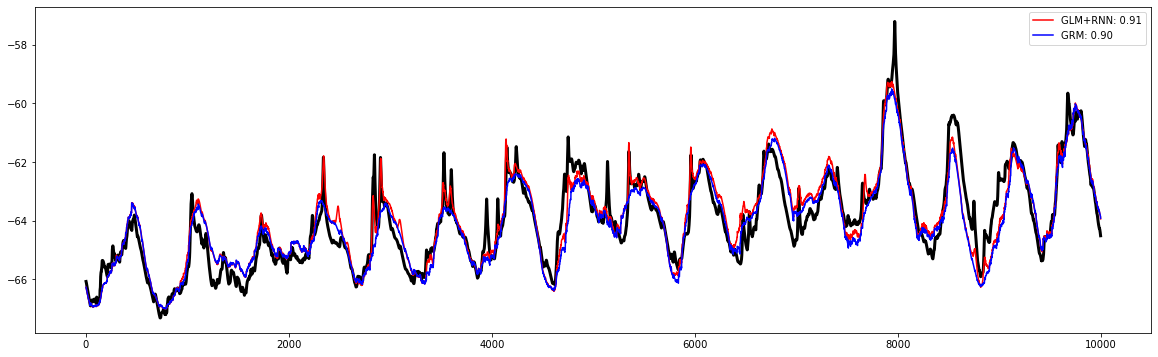

In [32]:
plt.figure(figsize = (20,6))
plt.plot(V[T_train:T_train+T_test][16000:26000], c="black", linewidth=3)
plt.plot(new[16000:26000], c="red", linewidth=1.5, label="GLM+RNN: 0.91")
plt.plot(old[16000:26000], c="blue", linewidth=1.5, label="GRM: 0.90")
plt.legend()

In [18]:
old_score = metrics.explained_variance_score(y_true=V[T_train:T_train+T_test], y_pred=old)
new_score = metrics.explained_variance_score(y_true=V[T_train:T_train+T_test], y_pred=new)
print(old_score, new_score)

0.9019254798287748 0.9101737598353653


In [20]:
vmin = np.min(V[T_train:T_train+T_test].cpu().detach().numpy())
vmax = np.max(V[T_train:T_train+T_test].cpu().detach().numpy())
print(vmin, vmax)

-68.3 -57.20419977223567


In [21]:
min_val = -68.5
max_val = -57
step = 0.5
step_no = int((max_val - min_val)/step)

new_array = np.empty((step_no,2))
old_array = np.empty((step_no,2))

for i in range(step_no):
    idx = np.where((V[T_train:T_train+T_test].cpu().detach().numpy()>=min_val+i*step) & (V[T_train:T_train+T_test].cpu().detach().numpy()<min_val+(i+1)*step))
    old_mean = np.mean(old[idx])
    old_std = np.std(old[idx])
    new_mean = np.mean(new[idx])
    new_std = np.std(new[idx])
    
    new_array[i,0] = new_mean
    new_array[i,1] = new_std
    old_array[i,0] = old_mean
    old_array[i,1] = old_std

In [37]:
fig, axs = plt.subplots(ncols=2, figsize = (15,5))
axs[0].plot(np.arange(min_val, max_val, step), old_array[:,0], label="GLM")
axs[0].plot(np.arange(min_val, max_val, step), new_array[:,0], label="GLM+RNN")
axs[0].set_xlabel("True V")
axs[0].set_ylabel("Predicted V Mean")
axs[0].legend()

axs[1].plot(np.arange(min_val, max_val, step), old_array[:,1], label="GLM")
axs[1].plot(np.arange(min_val, max_val, step), new_array[:,1], label="GLM+RNN")
axs[1].set_xlabel("True V")
axs[1].set_ylabel("Predicted V STD")
axs[1].legend()

SyntaxError: invalid syntax (<ipython-input-37-a3df8ec055b1>, line 2)